In [1]:
import numpy as np
import sympy as sp
import svg.path as svg
import matplotlib.pyplot as plt
import xml.dom.minidom as md
import matplotlib.animation as animation

from scipy.fftpack import fft
from scipy.fftpack import ifft
from scipy.integrate import quad_vec
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
from svg.path import Path, Line, Arc, CubicBezier, QuadraticBezier, Close, parse_path
from xml.dom.minidom import parse

%matplotlib notebook

In [2]:
# Get SVG file path
filepath = "./MikuCurveTest.svg"
svg_file = md.parse(filepath)

# Use libray to phase SVG file.
rootNode = svg_file.documentElement
svg_path_node = rootNode.getElementsByTagName("path")

# Open with xml and phase
for node in svg_path_node:
    if not node.hasAttribute("d"):
        raise AttributeError()
    else:
        svg_path_temp = node.getAttribute("d")
        break
        
    svg_path_temp = [str(i) for i in svg_path_temp]

# Remove path with line
curve_path = parse_path(svg_path_temp)
for path in curve_path:
    if type(path) == svg.path.Line:
        curve_path.remove(path)

In [3]:
# Complex number get real and imag.
def complexToReal(num: complex):
    x = round(float(num.real), 2)
    y = round(float(num.imag), 2)
    return (x, y)

# Get bezier curve control point from path.
def getControlPoint(path):
    
    p0 = complexToReal(path.start)
    p1 = complexToReal(path.control1)
    p2 = complexToReal(path.control2)
    p3 = complexToReal(path.end)
    
    return p0, p1, p2, p3

# Check bezier curve continutiy(optional, debug).
def continuityCheck(curve_path):
    count = 0
    p3_temp = None
    for path in curve_path:
        
        if type(path) == svg.path.CubicBezier:
            p0, p1, p2, p3 = getControlPoint(path)
        else: 
            count += 1
            continue
            
        if p3_temp != None and p3_temp != p0:
            print(f"At count {count} {path_temp} and {path} is not continuity.")
            return False
        count += 1
        
        p3_temp, path_temp = p3, path
    return True

# Simplify bezeir Curve as: f(t) = A*t^3 + B*t^2 + C*t + D .
def calcConst(path, axis):
    
    # B(t) = at^3 + bt^2 + ct + d
    p0, p1, p2, p3 = getControlPoint(path)
    
    if axis == "x":
        p0, p1, p2, p3 = p0[0], p1[0], p2[0], p3[0]
    elif axis == "y":
        p0, p1, p2, p3 = p0[1], p1[1], p2[1], p3[1]
    elif axis == "xy":
        tp0 = str(p0[0]) + "+" + str(p0[1]) + "j"
        tp1 = str(p1[0]) + "+" + str(p1[1]) + "j"
        tp2 = str(p2[0]) + "+" + str(p2[1]) + "j"
        tp3 = str(p3[0]) + "+" + str(p3[1]) + "j"
        p0, p1, p2, p3 = complex(tp0), complex(tp1), complex(tp2), complex(tp3)
    else:
        raise ValueError("Only support x, y or xy.")
        
    a = p3 - 3*p2 + 3*p1 - p0
    b = 3*(p2 - 2*p1 +p0)
    c = 3*(p1 - p0)
    d = p0
    
    return a, b, c, d
        
# Cubic bezier curve formula function
def cubicBezierCurve(p0, p1, p2, p3, t):
    
    x = 1 * p0[0] * ((1 - t) ** 3) * (t ** 0) + 3 * p1[0] * ((1 - t) ** 2) * (t ** 1) + 3 * p2[0] * ((1 - t) ** 1) * (t ** 2) + 1 * p3[0] * ((1 - t) ** 0) * (t ** 3)
    y = 1 * p0[1] * ((1 - t) ** 3) * (t ** 0) + 3 * p1[1] * ((1 - t) ** 2) * (t ** 1) + 3 * p2[1] * ((1 - t) ** 1) * (t ** 2) + 1 * p3[1] * ((1 - t) ** 0) * (t ** 3)
    
    return (x, y)

# Print config function(offset, rotation).
def printCubicBezierCurves(t, path, mirror = None, offset = (0, 0)):
    
    """
    mirror = None : Primitive function
    mirror = "x"  : Function symmetric about x axis
    mirror = "y"  : Function symmetric about y axis
    mirror = "xy" : Function symmetric about origin point
    """
    
    p0, p1, p2, p3 = getControlPoint(path)
    x, y = cubicBezierCurve(p0, p1, p2, p3, t)  
    
    if mirror == None: return (x + offset[0], y + offset[1])
    elif mirror == "x": return (-x + offset[0], y + offset[1])
    elif mirror == "y": return (x + offset[0], -y + offset[1])
    elif mirror == "xy": return (-x + offset[0], -y + offset[1])

<IPython.core.display.Javascript object>


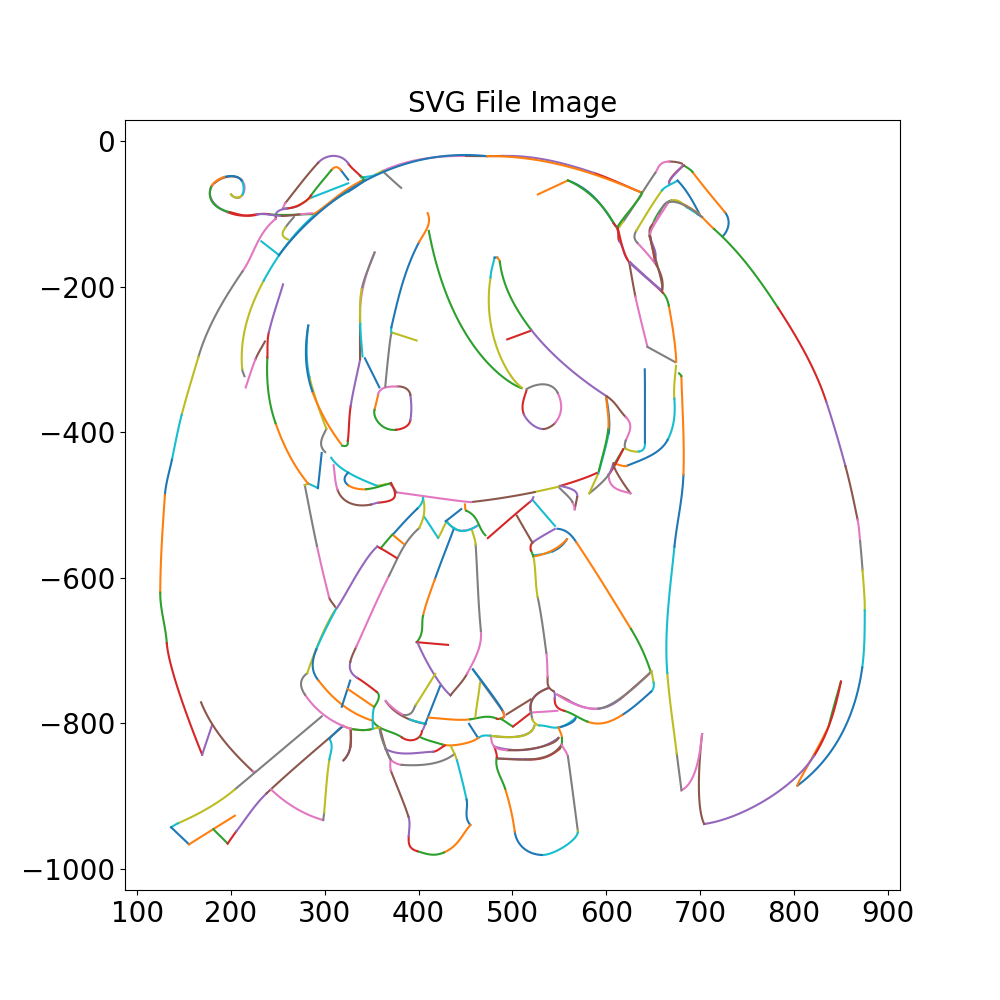

Total 368 Cubic Bezier Curves.


In [4]:
# Sampling rate of single part of all bezier curve
SAMPLING_RATE = 100

plt.figure(figsize = (10, 10))
plt.title("SVG File Image", fontsize = 20)
plt.tick_params(labelsize = 20)

np_point_list = []
curve_const_list, curve_const_list_x, curve_const_list_y = [], [], []
point_list_x, point_list_y, point_list = [], [], []
t = np.linspace(0, 1, SAMPLING_RATE)

# Discretization curve to point and save.
for path in curve_path:
    if type(path) == svg.path.Move:
        pass

    elif type(path) == svg.path.Line:
        pass

    elif type(path) == svg.path.CubicBezier:
        x, y = printCubicBezierCurves(t, path, "y")
        
        for i in range(len(x)):
            point_list_x.append(x[i])
            point_list_y.append(y[i])
        
        plt.plot(x, y)

    elif type(path) == svg.path.Close:
        break

    else:
        raise TypeError(f"Unexpected type: {type(path)}")

array_x, array_y = np.array(point_list_x), np.array(point_list_y)
plt.show()

curve_count = int(sum([type(i) == svg.path.CubicBezier for i in curve_path]))
print(f"Total {curve_count} Cubic Bezier Curves.")

In [5]:
# Circle count = CIRCLE from [-order] to [order]
#        with length = 2 * order + 1
order = 500
array_x = array_x - np.mean(array_x)
array_y = array_y - np.mean(array_y)
array_t = np.linspace(0, 2*np.pi, len(array_x))

In [6]:
# Calulate the parameter C

C = []

def f(t, array_t, array_x, array_y):
    return np.interp(t, array_t, array_x + 1j*array_y)

for n in range(-order, order + 1):
    coef = 1/(2*np.pi) * quad_vec(lambda t: f(t, array_t, array_x, array_y)*np.exp(-n*t*1j), 0, 2*np.pi, limit=100, full_output=1)[0]
    C.append(coef)

np.save('/C.npy', np.array(C))

In [7]:
# Sort C with index 0, 1, -1, 2, -2, 3, -3, ...
def sort_coeff(coeffs):
    new_coeffs, index = [], []
    new_coeffs.append(coeffs[order])
    index.append(0)
    for i in range(1, order+1):
        new_coeffs.extend([coeffs[order+i],coeffs[order-i]])
        index.extend([i,-i])
    return new_coeffs, index

coeffs_list, lable = sort_coeff(C)
coeffs = np.array(coeffs_list)

x_coeffs = np.real(coeffs)
y_coeffs = np.imag(coeffs)

In [8]:
def getCircle(start, end, sr = 100):
    a, b, c, d = start[0], start[1], end[0], end[1]
    r = ((a - c)**2 + (b - d)**2) ** 0.5
    theta = np.linspace(0, 2 * np.pi, sr)
    x = r * np.cos(theta) + a
    y = r * np.sin(theta) + b
    return x, y

def drawCircle(start, end, sr = 100):
    x, y = getCircle(start, end, sr)
    return plt.plot(x, y, color="blue", linewidth = 1, alpha = 0.3)

def getLine(start, end):
    line_x = np.linspace(start[0], end[0], 100)
    line_y = np.linspace(start[1], end[1], 100)
    return line_x, line_y

def drawLine(start, end):
    x, y = getLine(start, end)
    return plt.plot(x, y)

def calcRadius(t_index, t_list = array_t, para_C = coeffs, lable = np.array(lable)):
    t = t_list[t_index]
    vector = para_C * np.exp(lable * 1j * t)
    vector_x, vector_y = vector.real, vector.imag
    return (vector_x, vector_y)

In [9]:
# Calculate vector
temp_vector_list = []
vector = []
for i in range(len(array_t)):
    temp_vector_list.append(calcRadius(i))
temp_vector = np.array(temp_vector_list)

for i in range(len(temp_vector)):
    vector.append(temp_vector[i].T)
vector = np.array(vector)

In [10]:
# Get FFT fit result(sum all vector)
vector_x = vector[:, :, 0]
vector_y = vector[:, :, 1]    
x_sum = np.sum(vector_x, axis = 1, keepdims = True)
y_sum = np.sum(vector_y, axis = 1, keepdims = True)

<IPython.core.display.Javascript object>


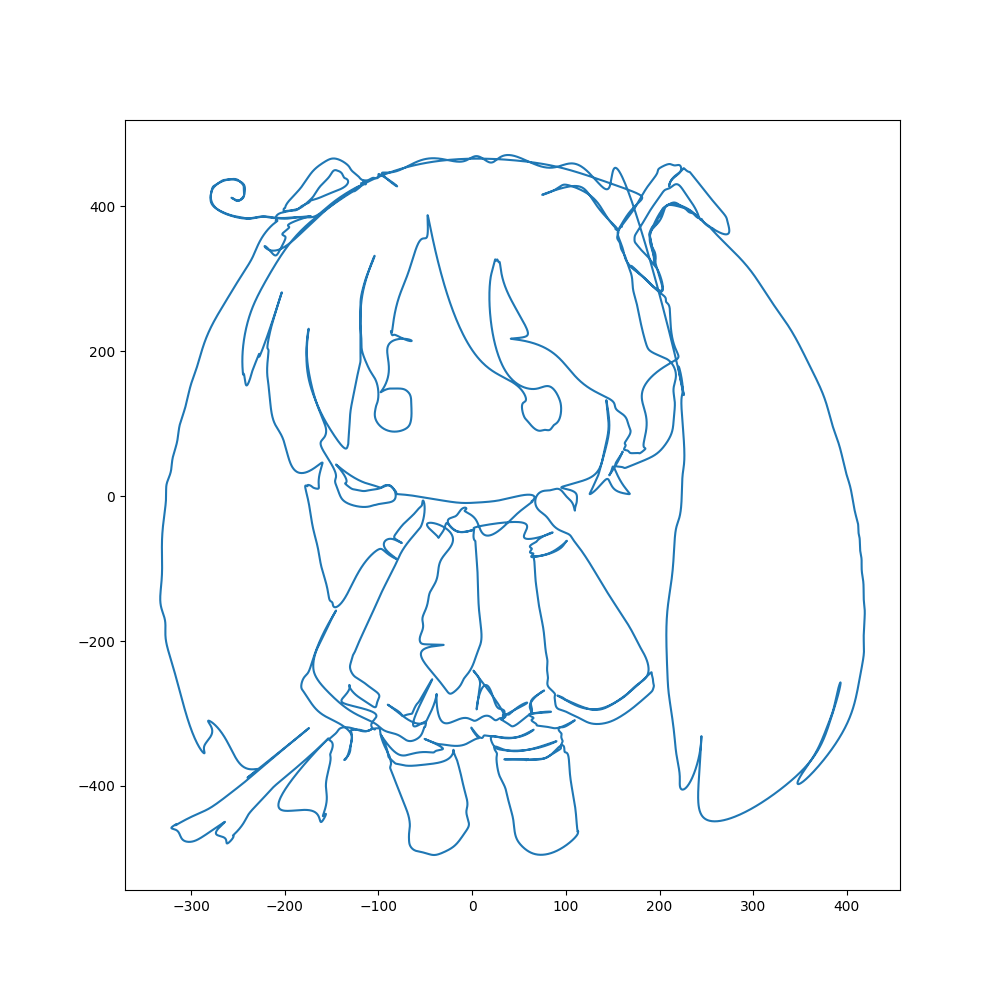

In [11]:
# Print FFT fit result
plt.figure(figsize=(10, 10))
plt.plot(x_sum, y_sum)
plt.show()

In [12]:
# Calulate vector into point set.
point_vector = np.zeros(vector.shape)

for t in range(array_t.shape[0]):
    temp_sum_x, temp_sum_y = 0.0, 0.0
    for i in range(vector[t, :, :].shape[0]):
        point_vector[t][i] = [temp_sum_x, temp_sum_y]
        temp_sum_x += vector[t][i][0]
        temp_sum_y += vector[t][i][1]

In [13]:
# Create start-end tuple from point set.
def getPointList(t):
    pointList = []
    tempList = point_vector[t]
    for i in range(len(tempList) - 1):
        pointList.append([tempList[i], tempList[i+1]])
    return pointList

# Calculate animate xy-limit. 
def calcXYlimit(array):
    squ_max = abs(float(np.max(array)))
    squ_min = abs(float(np.min(array)))
    squ_lim = max(squ_max, squ_min)
    return (squ_lim // 50 + 1) * 50

In [14]:
# Create Animation with plt
fig, ax = plt.subplots(figsize=(6,6))

lines, circles = [], []
point_x, point_y = [], []

lim = calcXYlimit(np.array([x_sum, y_sum]))
ax.set(xlim = [-lim, lim], ylim = [-lim, lim])

def initalize():
    start_end_list = getPointList(0)
    
    global scatter 
    scatter = ax.plot([], [])[0]
    
    for i in range(len(start_end_list)):
        lines.append(ax.plot([], [], alpha=0.7)[0])
        circles.append(ax.plot([], [], alpha=0.7)[0])

def update(data):
    start_end_list = getPointList(data)

    for i in range(len(start_end_list)):
        
        line_x, line_y = getLine(start_end_list[i][0], start_end_list[i][1])
        lines[i].set_data(line_x, line_y)
        
        circle_x, circle_y = getCircle(start_end_list[i][0], start_end_list[i][1])
        circles[i].set_data(circle_x, circle_y)
        
    point_x = x_sum[0 : data, 0]
    point_y = y_sum[0 : data, 0]
    
    scatter.set_data(point_x, point_y)
        
ani = FuncAnimation(fig, update, init_func = initalize, frames = range(len(x_sum)), interval = 1)
ani.save("movie.mp4", fps = 120, writer="ffmpeg")
# ani.save('animation.gif', writer='imagemagick', fps = 20, )
plt.show()

<IPython.core.display.Javascript object>